# [Case Study Project](https://cloud-school.thinkific.com/courses/take/analytics-with-python-module/texts/48739139-case-study)
## Analyze the Sakila database
## Group 3
## Week 6
### Gabriel Osasumwen Okundaye, gabriel.okundaye@azubiafrica.org 🌍


### Requirements
You are to connect to a remote database using python code. Properly set up your connection to the database using the database credentials provided below. It is a must to hide sensitive information like password, hostname, username, etc. using environment variables.
Once your setup is done, query the database to answer the following analytical questions by writing an SQL query in your Jupyter notebook and supply the appropriate visualization.

### Questions
1. Determine how much we made in revenue from active and inactive members. Visualize the result as a bar chart.<br>
2. We have 2 staff members, Mike and Jon. Determine the staff member that contributed the most to our revenue in the month of August in 2005. Visualize their percentage contribution as a pie chart.<br>
3. Create a simple line chart showing the monthly rental count of the store. Do you notice any patterns or trends?<br>
4. Create a basic bar chart to show the monthly revenue for the rental store.<br>


In [ ]:
# Install needed packages
%pip install sqlalchemy mysqlclient mysql-connector-python python-dotenv

In [ ]:
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine

load_dotenv()

username   = os.getenv('USERNAME')
host       = os.getenv('HOST')
password   = os.getenv('PASSWORD')
db_name    = os.getenv('DATABASE_NAME')

# Create the DB engine connector
connection = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}/{db_name}")

print(connection)



### Question 1: Determine how much we made in revenue from active and inactive members. Visualize the result as a bar chart.

In [4]:
db_query = '''
    SELECT c.customer_id, c.active, p.amount 
    FROM customer as c
        INNER JOIN payment as p
        ON c.customer_id = p.customer_id   
'''

df_members = pd.read_sql(db_query, connection)

# df_members.rename({'customer_id': 'member_id'}, axis=1, inplace=True)
df_members.rename(columns={'customer_id': 'member_id'}, inplace=True)

df_members.head()

,member_id,active,amount
0,1,1,2.99
1,1,1,0.99
2,1,1,5.99
3,1,1,0.99
4,1,1,9.99


In [5]:
# Check for missing values
df_members.isna().sum()

member_id    0
active       0
amount       0
dtype: int64

In [6]:
def status_text(status):
    '''Returns the status text of a status number'''
    status_text = 'Active members' if (status==1) else 'Inactive members'
    return status_text

revenue_by_members = (
    df_members
    .groupby(by='active', as_index=True)
    ['amount']
    .sum()
    .rename('revenue')    
)

revenue_by_members.index = revenue_by_members.index.map(status_text)

revenue_by_members.info()


<class 'pandas.core.series.Series'>
Index: 2 entries, Inactive members to Active members
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
2 non-null      float64
dtypes: float64(1)
memory usage: 32.0+ bytes


In [7]:
revenue_by_members

active
Inactive members     1659.96
Active members      65746.60
Name: revenue, dtype: float64

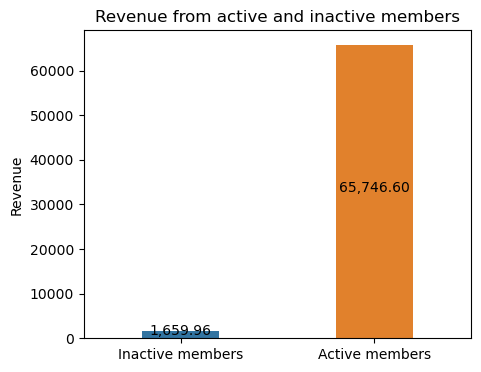

In [38]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot bar chart
# Create a figure and axes using Matplotlib
fig, ax = plt.subplots(figsize=(5, 4))

# Values needed for plot
# X axis
x = revenue_by_members.index
# Y axis
y = revenue_by_members.values

sns.barplot(x=x, y=y, ax=ax, errorbar=None, width=0.4, hue=x) 

ax.set(
    xlabel = '',
    ylabel = 'Revenue',
    title  = 'Revenue from active and inactive members'
)

# Add data labels to bars
for x,y in zip(x, y):
    label = f'{y:,.2f}'
    p = y//2
    plt.text(x, p, label, ha='center')

# Display revenue members 
plt.show()


In [9]:
print(f"The revenue from active and inactive members are \
{revenue_by_members[  'Active members']:,.2f} and \
{revenue_by_members['Inactive members']:,.2f} respectively."
)

The revenue from active and inactive members are 65,746.60 and 1,659.96 respectively.


### QUESTION 2: We have 2 staff members, Mike and Jon. Determine the staff member that contributed the most to our revenue in the month of August in 2005. Visualize their percentage contribution as a pie chart.

In [10]:
db_query   = '''
    SELECT s.staff_id, s.first_name, s.last_name, s.email, p.amount, p.payment_date 
    FROM staff as s
        INNER JOIN payment as p
        ON s.staff_id = p.staff_id
        WHERE (month(p.payment_date) = 8 AND year(p.payment_date) = 2005)    
'''

df_staff = pd.read_sql(db_query, connection)

df_staff.head()

,staff_id,first_name,last_name,email,amount,payment_date
0,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,0.99,2005-08-02 18:01:38
1,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,0.99,2005-08-18 03:57:29
2,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,0.99,2005-08-21 23:33:57
3,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,1.99,2005-08-22 01:27:57
4,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,5.99,2005-08-22 20:03:46


In [11]:
df_staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5686 entries, 0 to 5685
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   staff_id      5686 non-null   int64         
 1   first_name    5686 non-null   object        
 2   last_name     5686 non-null   object        
 3   email         5686 non-null   object        
 4   amount        5686 non-null   float64       
 5   payment_date  5686 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 266.7+ KB


In [12]:
# Check for missing values
df_staff.isna().sum()

staff_id        0
first_name      0
last_name       0
email           0
amount          0
payment_date    0
dtype: int64

In [13]:
revenue_by_staff = (
    df_staff
    .groupby(by=['staff_id','first_name', 'last_name', 'email'])
    .agg(revenue=pd.NamedAgg('amount', 'sum'))
    .reset_index()
    .set_index('staff_id')
)

revenue_by_staff

,first_name,last_name,email,revenue
staff_id,,,,
1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,11853.65
2,Jon,Stephens,Jon.Stephens@sakilastaff.com,12216.49


*It can be observed that Jon Stephens generated the most revenue at 12,216.49, although Mike Hillyer came close at 11,853.65*

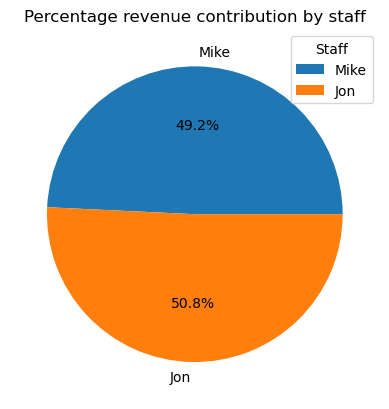

In [14]:
# Visualisation
import matplotlib.pyplot as plt

plt.pie(
        x       = revenue_by_staff['revenue'],        
        labels  = revenue_by_staff['first_name'], 
        autopct = '%.1f%%'
)

plt.legend(title='Staff')

plt.title("Percentage revenue contribution by staff")

plt.show()


*It is evident that the staff member- Jon contributed the most revenue 50.8% in the month of August 2005*

### Question 3: Create a simple line chart showing the monthly rental count of the store. Do you notice any patterns or trends?<br>


In [15]:
db_query = '''
    SELECT i.store_id, p.rental_id, p.amount, r.rental_date 
    FROM rental as r
        INNER JOIN inventory as i
        ON r.inventory_id = i.inventory_id
        INNER JOIN payment as p
        ON r.rental_id = p.rental_id    
'''

df_rental_store = pd.read_sql(db_query, connection)

# Rename column amount to revenue
df_rental_store.rename(columns={'amount': 'revenue'}, inplace=True)

# Convert the store_id column to categorical type
df_rental_store['store_id'] = pd.Categorical(df_rental_store['store_id'])

df_rental_store.head()

,store_id,rental_id,revenue,rental_date
0,1,4863,0.99,2005-07-08 19:03:15
1,1,11433,3.99,2005-08-02 20:13:10
2,1,14714,3.99,2005-08-21 21:27:43
3,1,972,1.99,2005-05-30 20:21:07
4,1,2117,0.99,2005-06-17 20:24:00


In [16]:
df_rental_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   store_id     16044 non-null  category      
 1   rental_id    16044 non-null  int64         
 2   revenue      16044 non-null  float64       
 3   rental_date  16044 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 391.9 KB


In [17]:
# Check for missing values
df_rental_store.isna().sum()

store_id       0
rental_id      0
revenue        0
rental_date    0
dtype: int64

In [18]:
df_rental_store.describe()

,rental_id,revenue,rental_date
count,16044.000000,16044.000000,16044
mean,8025.371478,4.201356,2005-07-23 08:12:53.217526912
min,1.000000,0.000000,2005-05-24 22:53:30
25%,4013.750000,2.990000,2005-07-07 00:58:40.500000
50%,8025.500000,3.990000,2005-07-28 16:04:32.500000
75%,12037.250000,4.990000,2005-08-17 21:16:23
max,16049.000000,11.990000,2006-02-14 15:16:03
std,4632.777249,2.362961,NaN


In [19]:
# Quick plot
# (
#     df_rental_store
#     .set_index('rental_date')
#     .resample('M')
#     .size()
#     .plot()
# )

In [20]:
# Monthly rental df
monthly_rental = (
    df_rental_store
    .set_index('rental_date')
    .sort_index(ascending=True)
    .resample('MS')
    .size()
    .rename('rental_count')
)

monthly_rental.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 10 entries, 2005-05-01 to 2006-02-01
Freq: MS
Series name: rental_count
Non-Null Count  Dtype
--------------  -----
10 non-null     int64
dtypes: int64(1)
memory usage: 160.0 bytes


In [21]:
# Check monthly_rental
monthly_rental

rental_date
2005-05-01    1156
2005-06-01    2311
2005-07-01    6709
2005-08-01    5686
2005-09-01       0
2005-10-01       0
2005-11-01       0
2005-12-01       0
2006-01-01       0
2006-02-01     182
Freq: MS, Name: rental_count, dtype: int64

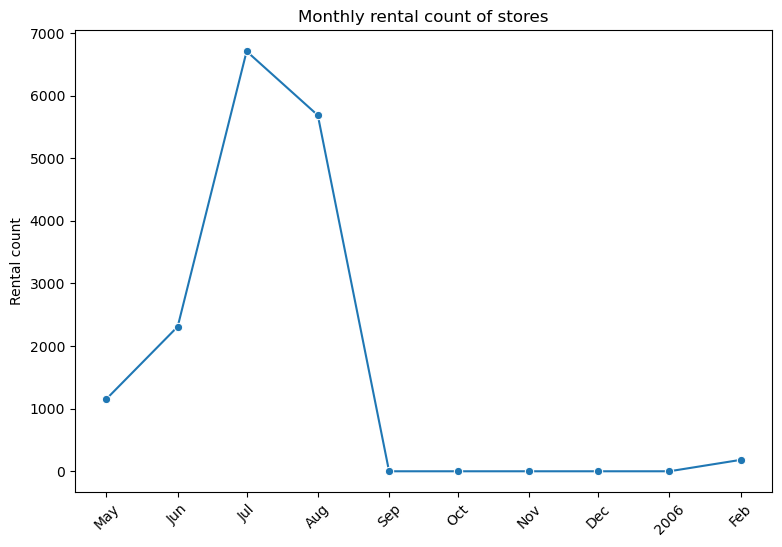

In [22]:
# Visualization 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Plot line chart with proper month date axis
plt.figure(figsize=(9, 6))

locator   = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(locator)

sns.lineplot(x=monthly_rental.index, y=monthly_rental.values, marker='o')

plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlabel('')
plt.ylabel('Rental count')
plt.title('Monthly rental count of stores')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='center')

# Display monthly_rental count
plt.show()

## Trend
- May 2005: The combined rental count is **1156**, indicating a moderate level of rental activity.
- June 2005: There is an increase in the combined rental count to **2311**, suggesting a higher demand for rentals in this month compared to May 2005.
- July 2005: The combined rental count experiences a significant jump to **6709**, indicating a substantial increase in rental activity.  This could be influenced by factors such as seasonal trends, promotions, or increased customer demand.
- August 2005: The rental count decreases to **5686**, but it remains relatively high compared to the previous months.
- September 2005 to January 2006: There are no recorded rentals during this period for both stores, as the combined rental count is **0**.This suggests a period of inactivity or zero rental transactions.
- February 2006: There is a slight increase in the combined rental count to **182**, indicating a resumption of rental activity

#### Overall:
- There was variation in rental counts over the months, with peaks observed in July 2005.
- The period from September 2005 to January 2006 represents a period of inactivity with no recorded rentals.
- February 2006 shows a moderate increase in rental activity compared to the inactive months.

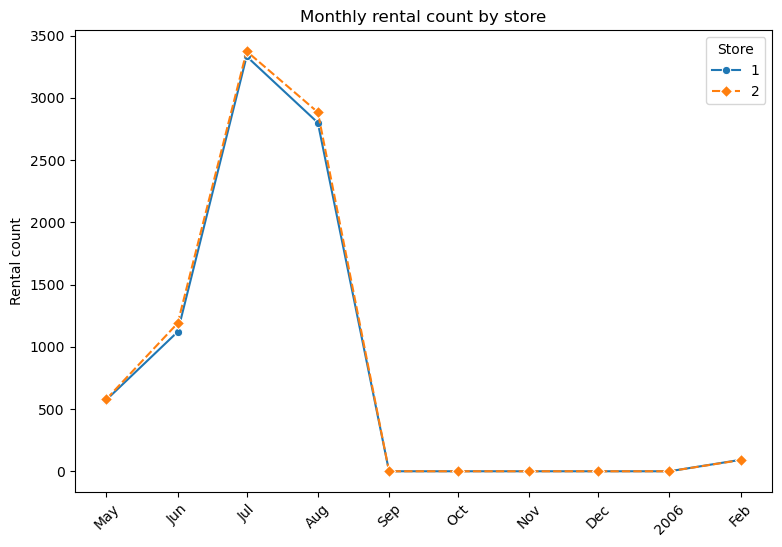

In [23]:
# Visualization 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

monthly_rental_bystore = (
   df_rental_store
   # Set index as rental date
   .set_index('rental_date')
   # Sort index in ascending order
   .sort_index(ascending=True)
   # Group by store_id
   .groupby(by='store_id', observed=False)
   # Resample by Month using Month Start MS frequency
   .resample('MS')
   # Count the observations
   .size()
   # Name the series
   .rename('rental_count')
)

# Plot line chart with proper month date axis
plt.figure(figsize=(9, 6))

# Values needed for plot
# X axis
x = monthly_rental_bystore.index.get_level_values('rental_date')
# Y axis
y=monthly_rental_bystore.values
# Hue
h=monthly_rental_bystore.index.get_level_values('store_id')
# Style
s=monthly_rental_bystore.index.get_level_values('store_id')  
# Markers
m = ['o', 'D']   
      
sns.lineplot(x = x, y = y, hue = h, style = s, markers = m)

locator   = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('')
plt.ylabel('Rental count')
plt.legend(title='Store')
plt.title('Monthly rental count by store')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='center')

# Display monthly_rental_bystore count
plt.show()

**It is evident that:**<br>
#### Store 1: <br>
- In May 2005, there were **575** rentals.<br>
- The rental count increased in June 2005 to **1121**.<br>
- A steep increase is observed in July 2005, reaching peak **3334** rentals.<br>
- The rental count decreases in August 2005 to **2801**.<br>
- From September 2005 to January 2006, there are no recorded rentals (rental count is 0).<br>
- In February 2006, there is a slight increase with **92** rentals.<br>

#### Store 2: <br>
- In similar trend to Store 1, Store 2 shows an increase in rental count from May 2005 **(581 rentals)** to June 2005 **(1190 rentals)**.<br>
- July 2005 saw a substantial increase in rental count, reaching **3375**.<br>
- The rental count decreases in August 2005 to **2885**.<br>
- Similar to Store 1, there are no recorded rentals from September 2005 to January 2006.<br>
- In February 2006, there is a slight increase with **90** rentals.<br>

#### Overall:
- Both stores had increases in rental counts in June and July, with peak values observed in July 2005.
- There is a period of inactivity with no recorded rentals from September 2005 to January 2006 for both stores.
- Both stores show a similar pattern of rental counts over time, with increases, decreases, and periods of inactivity.

In [24]:
monthly_rental_bystore

store_id  rental_date
1         2005-05-01      575
          2005-06-01     1121
          2005-07-01     3334
          2005-08-01     2801
          2005-09-01        0
          2005-10-01        0
          2005-11-01        0
          2005-12-01        0
          2006-01-01        0
          2006-02-01       92
2         2005-05-01      581
          2005-06-01     1190
          2005-07-01     3375
          2005-08-01     2885
          2005-09-01        0
          2005-10-01        0
          2005-11-01        0
          2005-12-01        0
          2006-01-01        0
          2006-02-01       90
Name: rental_count, dtype: int64

### Question 4: Create a basic bar chart to show the monthly revenue for the rental store.

In [25]:
# Monthly revenue with considering separate stores
monthly_revenue = (
    df_rental_store
    .set_index('rental_date')
    .sort_index(ascending=True)
    .resample('MS')
    ['revenue']
    .sum()                  
)

monthly_revenue.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 10 entries, 2005-05-01 to 2006-02-01
Freq: MS
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


In [26]:
monthly_revenue

rental_date
2005-05-01     4823.44
2005-06-01     9629.89
2005-07-01    28368.91
2005-08-01    24070.14
2005-09-01        0.00
2005-10-01        0.00
2005-11-01        0.00
2005-12-01        0.00
2006-01-01        0.00
2006-02-01      514.18
Freq: MS, Name: revenue, dtype: float64

In [27]:
# Ensure dates are in the correct format
from datetime import datetime
assert all(isinstance(date, datetime) for date in monthly_revenue.index), "Dates should be datetime objects"

In [28]:
# Convert rental date to month period
monthly_revenue.index = monthly_revenue.index.to_period('M')

In [29]:
monthly_revenue

rental_date
2005-05     4823.44
2005-06     9629.89
2005-07    28368.91
2005-08    24070.14
2005-09        0.00
2005-10        0.00
2005-11        0.00
2005-12        0.00
2006-01        0.00
2006-02      514.18
Freq: M, Name: revenue, dtype: float64

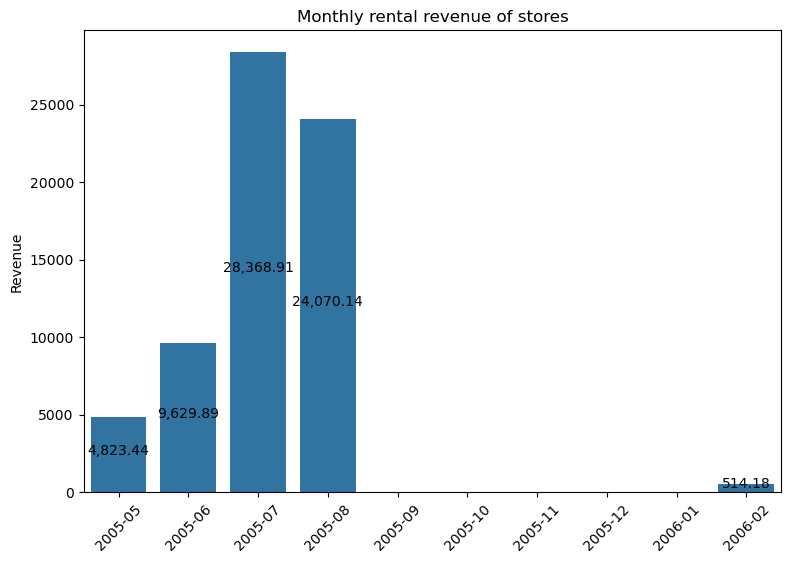

In [30]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Plot bar chart with proper month date axis
# Create a figure and axes using Matplotlib
fig, ax = plt.subplots(figsize=(9, 6))

# Values need for plot
x = monthly_revenue.index.astype(str)
y = monthly_revenue.values

sns.barplot(
    x = x, 
    y = y, 
    ax = ax, 
    errorbar = None
) 

ax.set(
    xlabel = '',
    ylabel = 'Revenue',
    title  = 'Monthly rental revenue of stores'
)

# Add data labels to bars
for x,y in zip(x, y):
    label = f'{y:,.2f}' if (y!=0) else ''
    p     = y//2
    plt.text(x, p, label, ha='center')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='center')

# Display monthly_rental revenue of store
plt.show()

# Summary
- May 2005: **4,823.44** rental revenue.
- June 2005: Significant increase to **9,629.89**.
- July 2005: Peak revenue at **28,368.91**.
- August 2005: Maintains strong revenue at **24,070.14**.
- September 2005 to January 2006: No recorded revenue, indicating inactivity.
- February 2006: Rental revenue resumes at **514.18**.

In [31]:
df_rental_store.head(2)

,store_id,rental_id,revenue,rental_date
0,1,4863,0.99,2005-07-08 19:03:15
1,1,11433,3.99,2005-08-02 20:13:10


In [32]:
# Monthly revenue considering separate stores
monthly_revenue_stores = (
    df_rental_store
    .set_index('rental_date')
    .sort_index(ascending=True)
    .groupby(by='store_id', observed=False)
    .resample('MS')
    ['revenue']
    .sum()                                     
)

monthly_revenue_stores.info()

<class 'pandas.core.series.Series'>
MultiIndex: 20 entries, (1, Timestamp('2005-05-01 00:00:00')) to (2, Timestamp('2006-02-01 00:00:00'))
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
20 non-null     float64
dtypes: float64(1)
memory usage: 903.0 bytes


In [33]:
monthly_revenue_stores

store_id  rental_date
1         2005-05-01      2459.25
          2005-06-01      4734.79
          2005-07-01     14308.66
          2005-08-01     11933.99
          2005-09-01         0.00
          2005-10-01         0.00
          2005-11-01         0.00
          2005-12-01         0.00
          2006-01-01         0.00
          2006-02-01       243.10
2         2005-05-01      2364.19
          2005-06-01      4895.10
          2005-07-01     14060.25
          2005-08-01     12136.15
          2005-09-01         0.00
          2005-10-01         0.00
          2005-11-01         0.00
          2005-12-01         0.00
          2006-01-01         0.00
          2006-02-01       271.08
Name: revenue, dtype: float64

In [34]:
# MultiIndex Series
# Change 'rental_date' level to monthly period
monthly_revenue_stores.index = (
        monthly_revenue_stores.index.set_levels(
                monthly_revenue_stores.index.levels[1].to_period('M'),
                level=1
        )
)

In [35]:
monthly_revenue_stores.head(2)

store_id  rental_date
1         2005-05        2459.25
          2005-06        4734.79
Name: revenue, dtype: float64

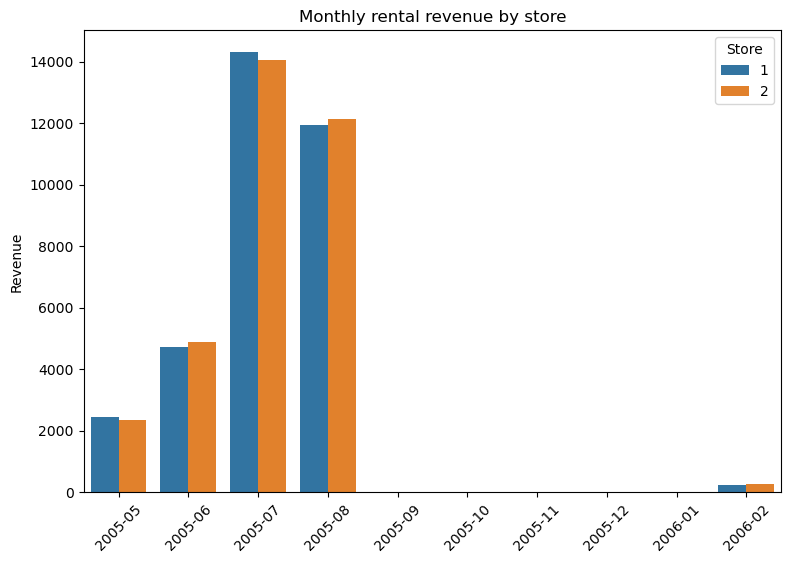

In [36]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Plot bar chart with proper month date axis
# Create a figure and axes using Matplotlib

fig, ax = plt.subplots(figsize=(9, 6))

# Values needed for plot
# X axis
x = monthly_revenue_stores.index.get_level_values('rental_date').astype(str)
# Y axis
y = monthly_revenue_stores.values
# Hue
h = monthly_revenue_stores.index.get_level_values('store_id')

sns.barplot(x=x, y=y, hue=h, ax=ax) 

ax.set(
    xlabel = '',
    ylabel = 'Revenue',
    title  = 'Monthly rental revenue by store'
    )

ax.legend(title='Store')  

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='center') 

# Display monthly_rental revenue by store
plt.show()

# Summary
#### Store 1:
- May 2005: **2,459.25** rental revenue.
- June 2005: Increases to **4,734.79**.
- July 2005: Peaks at **14,308.66**.
- August 2005: Maintains strong revenue at **11,933.99**.
- September 2005 to January 2006: No recorded revenue, indicating inactivity.
- February 2006: Revenue resumes at **243.10**.

#### Store 2:
- May 2005: **2,364.19** rental revenue.
- June 2005: Increases to **4,895.10**.
- July 2005: Peaks at **14,060.25**.
- August 2005: Maintains strong revenue at **12,136.15**.
- September 2005 to January 2006: No recorded revenue, indicating inactivity.
- February 2006: Revenue resumes at **271.08**.

# Thank You